In [1]:
# Kaggle TensorFlow Fix - Nov 2025
# import os
# import sys

# !pip install -q --no-cache-dir "protobuf==4.25.1" "tensorflow==2.16.2" --force-reinstall

# # Suppress warnings
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# # Restart kernel
# os.kill(os.getpid(), 9)
!pip install "tensorflow[and-cuda]"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 5.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2

In [1]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

2026-01-07 03:26:49.200570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767756409.409895      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767756409.467768      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
print("TF version:", tf.__version__)
print("GPUs detected:", tf.config.list_physical_devices('GPU'))

TF version: 2.18.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
BASE_PATH = '../input/coco-2017-dataset/coco2017'

In [6]:
# with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
#     data = json.load(f)
#     data = data['annotations']

# img_cap_pairs = []

# for sample in data:
#     img_name = '%012d.jpg' % sample['image_id']
#     img_cap_pairs.append([img_name, sample['caption']])

# captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
# captions['image'] = captions['image'].apply(
#     lambda x: f'{BASE_PATH}/train2017/{x}'
# )
# captions = captions.sample(50000, random_state=42)
# captions = captions.reset_index(drop=True)
# captions.head()

In [8]:
with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
    captions_json = json.load(f)

annotations = captions_json['annotations']

image_to_captions = collections.defaultdict(list)

for ann in annotations:
    image_to_captions[ann['image_id']].append(ann['caption'])

image_to_captions = {
    img_id: caps
    for img_id, caps in image_to_captions.items()
    if len(caps) >= 4
}

In [9]:
with open(f'{BASE_PATH}/annotations/instances_train2017.json', 'r') as f:
    instances_json = json.load(f)

instances = instances_json['annotations']
categories = instances_json['categories']

cat_id_to_name = {
    cat['id']: cat['name']
    for cat in categories
}

image_to_categories = collections.defaultdict(set)

for ann in instances:
    image_to_categories[ann['image_id']].add(ann['category_id'])

In [10]:
valid_image_ids = set(image_to_captions.keys()) & set(image_to_categories.keys())

category_to_images = collections.defaultdict(set)

for img_id in valid_image_ids:
    for cat_id in image_to_categories[img_id]:
        category_to_images[cat_id].add(img_id)

In [11]:
MIN_IMAGES_PER_CATEGORY = 1000
MAX_IMAGES_PER_CATEGORY = 3000

selected_images = set()

for cat_id, img_ids in category_to_images.items():
    img_ids = list(img_ids)
    # if len(img_ids) < MIN_IMAGES_PER_CATEGORY:
    #     continue
    random.shuffle(img_ids)

    n = min(
        max(len(img_ids), MIN_IMAGES_PER_CATEGORY),
        MAX_IMAGES_PER_CATEGORY
    )

    selected_images.update(img_ids[:n])

In [12]:
selected_images = list(selected_images)

if len(selected_images) > 50000:
    selected_images = random.sample(selected_images, 50000)

In [13]:
rows = []

for img_id in selected_images:
    caps = image_to_captions[img_id]
    chosen_caps = random.sample(caps, 4)

    img_name = f'{BASE_PATH}/train2017/{img_id:012d}.jpg'

    for cap in chosen_caps:
        rows.append([img_name, cap])

captions = pd.DataFrame(rows, columns=['image', 'caption'])
captions = captions.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
covered_categories = set()

for img in selected_images:
    covered_categories.update(image_to_categories[img])

len(covered_categories), len(categories)

(80, 80)

In [14]:
# with open(f"{BASE_PATH}/annotations/instances_train2017.json", "r") as f:
#     data = json.load(f)

# categories = data["categories"]
# annotations = data['annotations']

# maincategories = sorted(list(set(cat["supercategory"] for cat in categories)))

# print("Number of main categories:", len(maincategories))
# print("List of main categories:", maincategories)

# subcategories = [cat['name'] for cat in categories]

# print("Number of sub categories: ", len(subcategories))
# print("List of sub categories: ", subcategories)

# def getCatIds_byName(categories, catNms):
#     return [cat["id"] for cat in categories if cat["name"] in catNms]

# catIds = getCatIds_byName(categories, subcategories)

# subcategories_Ids = {
#     name: cid for name, cid in zip(subcategories, catIds)
# }

# print("Sub categories with IDs:", subcategories_Ids)

# def getImgIds_byCatId(annotations, catId):
#     return list({ann["image_id"] for ann in annotations if ann["category_id"] == catId})

# subcategories_imageIds = {}

# for name, cid in subcategories_Ids.items():
#     imgIds = getImgIds_byCatId(annotations, cid)
#     subcategories_imageIds[name] = imgIds

# length_dict = {key: len(value) for key, value in subcategories_imageIds.items()}
# print("Total images in each subcategory:", length_dict)


In [15]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [16]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

,image,caption
0,../input/coco-2017-dataset/coco2017/train2017/...,[start] a man on a beach where kites are being...
1,../input/coco-2017-dataset/coco2017/train2017/...,[start] a peeled banana in a cars cup holder [...
2,../input/coco-2017-dataset/coco2017/train2017/...,[start] three people water skiing at the same ...
3,../input/coco-2017-dataset/coco2017/train2017/...,[start] three birds in a parking lot near some...
4,../input/coco-2017-dataset/coco2017/train2017/...,[start] large christmas tree sitting in the mi...


[start] a glass sink that is under a faucet [end]



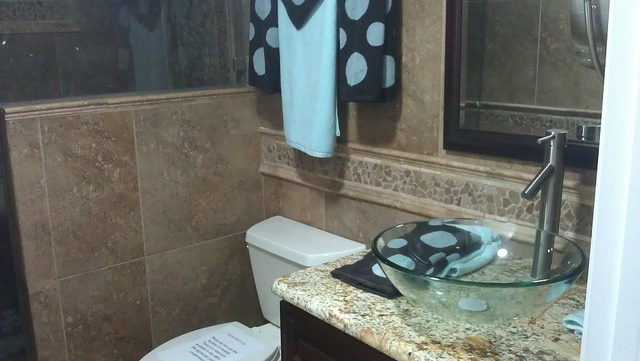

In [17]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

In [18]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 8002
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EPOCHS = 25

In [19]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens = VOCABULARY_SIZE,
    standardize = None,
    output_sequence_length = MAX_LENGTH,
)

tokenizer.adapt(captions['caption'])

I0000 00:00:1767545624.497991      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [20]:
tokenizer.vocabulary_size()

8002

In [21]:
import pickle

pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [22]:
vocab = tokenizer.get_vocabulary()
clean_vocab = [token for token in vocab if token not in ['', '[UNK]']]

In [23]:
word2idx = tf.keras.layers.StringLookup(
    vocabulary = clean_vocab,
    invert=False,
    mask_token = '',           
    oov_token = '[UNK]' 
)

idx2word = tf.keras.layers.StringLookup(
    vocabulary = clean_vocab,
    invert = True,
    mask_token = '',            
    oov_token = '[UNK]' 
)

In [24]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], 
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [25]:
print(len(set(train_imgs)), len(train_captions), len(set(val_imgs)), len(val_captions))

40000 160000 10000 40000


In [26]:
def load_data(img_path, caption):

    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(224, 224)(img)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [28]:
for imgs, caps in train_dataset.take(1):
    print(imgs.shape)
    print(caps.shape)

(64, 224, 224, 3)
(64, 40)


In [29]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [30]:
def CNN_encoder():

    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = False

    output = base_model.output   # shape: (None, 7, 7, 1280)
    output = tf.keras.layers.Reshape((-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(base_model.input, output)
    return cnn_model

In [31]:
class TransformerEncoder(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation='relu')

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_out = self.attention(
            query = x,
            key = x,
            value = x,
            attention_mask = None,
            training = training
        )

        x = self.layer_norm_2(x + attn_out)

        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
        })
        return config

In [32]:
class Embedding(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.token_embeddings = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(max_len, embed_dim)

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start = 0, limit = length, delta = 1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

    def get_config(self):
        config = super().get_config()
        config.update({
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "max_len": self.max_len,
        })
        return config

In [33]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads, vocab_size, max_len, **kwargs):
        super().__init__()
        self.embed_dim = embed_dim
        self.units = units
        self.num_heads = num_heads
        self.vocab_size = vocab_size
        self.max_len = max_len
        
        self.embedding = Embedding(vocab_size, embed_dim, max_len)

        self.encoder_proj = tf.keras.layers.Dense(embed_dim)

        key_dim = embed_dim // num_heads

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=key_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=key_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        # self.out = tf.keras.layers.Dense(vocab_size, activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.2)
        self.dropout_2 = tf.keras.layers.Dropout(0.2)

    def get_casual_attn_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, seq_length = input_shape[0], input_shape[1]
        i = tf.range(seq_length)[:, tf.newaxis]
        j = tf.range(seq_length)
        mask = tf.cast(i>=j, dtype='int32')
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        
        return tf.tile(mask, mult)

    def call(self, embeddings, encoder_output, training, causal_mask=None, padding_mask=None):
        # embeddings = self.embedding(input_ids)

        # causal_mask = None
        # causal_mask = self.get_casual_attn_mask(embeddings)
        # causal_mask = tf.cast(causal_mask, tf.float32)
        # padding_mask = None
        # combined_mask = causal_mask

        # if mask is not None:
        #     # causal_mask = self.get_casual_attn_mask(embeddings)
        #     padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.float32)
        #     padding_mask_2d = tf.cast(mask[:, tf.newaxis, :], dtype=tf.float32)
            # combined_mask = tf.minimum(padding_mask_2d, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=causal_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        enc_proj = self.encoder_proj(encoder_output)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=enc_proj,
            key=enc_proj,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        # preds = self.out(ffn_out)
        return ffn_out

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "units": self.units,
            "num_heads": self.num_heads,
            "vocab_size": self.vocab_size,
            "max_len": self.max_len,
        })
        return config

In [34]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, 
                 num_layers,
                 embed_dim, 
                 units, 
                 num_heads,
                 vocab_size,
                 max_len,
                 **kwargs):
        super().__init__(**kwargs)

        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.units = units
        self.num_heads = num_heads
        self.vocab_size = vocab_size
        self.max_len = max_len

        # shared embedding
        self.embedding = Embedding(vocab_size, embed_dim, max_len)

        # create N decoder blocks
        self.layers_list = [
            TransformerDecoderLayer(
                embed_dim=embed_dim,
                units=units,
                num_heads=num_heads,
                vocab_size=vocab_size,
                max_len=max_len
            )
            for _ in range(num_layers)
        ]

        # final projection layer
        self.final_dense = tf.keras.layers.Dense(vocab_size, activation="softmax")

    def get_causal_attn_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, seq_length = input_shape[0], input_shape[1]
        i = tf.range(seq_length)[:, tf.newaxis]
        j = tf.range(seq_length)
        mask = tf.cast(i >= j, dtype='int32')
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

    def call(self, input_ids, encoder_output, training, mask=None):

        # token + positional embeddings
        embeddings  = self.embedding(input_ids)

        causal_mask = self.get_causal_attn_mask(embeddings)
        causal_mask = tf.cast(causal_mask, tf.float32)
        
        # Create combined mask if padding mask provided
        combined_mask = causal_mask
        padding_mask = None
        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.float32)
            padding_mask_2d = tf.cast(mask[:, tf.newaxis, :], dtype=tf.float32)
            combined_mask = tf.minimum(padding_mask_2d, causal_mask)
        
        # Pass through each decoder block
        x = embeddings

        # pass through each decoder block
        for layer in self.layers_list:
            x = layer(x, encoder_output, training=training, 
                     causal_mask=combined_mask, padding_mask=padding_mask)

        # final prediction
        return self.final_dense(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "embed_dim": self.embed_dim,
            "units": self.units,
            "num_heads": self.num_heads,
            "vocab_size": self.vocab_size,
            "max_len": self.max_len
        })
        return config


In [35]:
class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, cnn_model, encoder, decoder, image_aug=None, **kwargs):
        super().__init__(**kwargs)
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        # loss = self.loss(y_true, y_pred)
        y_true_one_hot = tf.one_hot(y_true, depth=self.decoder.vocab_size)
        loss = self.loss(y_true_one_hot, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=training)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_input != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=training, mask= mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def call(self, inputs, training=False):
        # inputs is expected to be a list: [images, captions]
        images, captions = inputs
        
        # 1. extract features from image
        x = self.cnn_model(images, training=False)
        
        # 2. pass through encoder
        x = self.encoder(x, training=training)
        
        # 3. pass through decoder (captions + encoded images)
        # Note: Depending on your decoder, it might also need training=True/False
        y_pred = self.decoder(captions, x, training=training)
        
        return y_pred

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]


In [36]:
vocab_size = 8002
max_len = 40       
embed_dim = 256
units = 512

In [37]:
encoder = TransformerEncoder(embed_dim, 1)
decoder = TransformerDecoder(
    num_layers=4,          
    embed_dim=256,
    units=512,
    num_heads=4,
    vocab_size=vocab_size,
    max_len=max_len
)

cnn_model = CNN_encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [38]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # reduce LR by half
    patience=2,         # wait for 2 epochs of no improvement
    min_lr=1e-6,        # don't go below this
    verbose=1
)

In [42]:
cross_entropy = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction="none", label_smoothing=0.1
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

caption_model.cnn_model.trainable = False
caption_model.encoder.trainable = False
caption_model.decoder.trainable = True

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [43]:
history = caption_model.fit(
    train_dataset,
    epochs=7,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 616s 236ms/step - acc: 0.5142 - loss: 3.3053 - val_acc: 0.5193 - val_loss: 3.2794 - learning_rate: 0.0010
Epoch 2/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 584s 233ms/step - acc: 0.5159 - loss: 3.2769 - val_acc: 0.5206 - val_loss: 3.2758 - learning_rate: 0.0010
Epoch 3/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 602s 240ms/step - acc: 0.5176 - loss: 3.2628 - val_acc: 0.5210 - val_loss: 3.2756 - learning_rate: 0.0010
Epoch 4/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 585s 233ms/step - acc: 0.5186 - loss: 3.2536 - val_acc: 0.5217 - val_loss: 3.2687 - learning_rate: 0.0010
Epoch 5/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 591s 236ms/step - acc: 0.5197 - loss: 3.2450 - val_acc: 0.5222 - val_loss: 3.2654 - learning_rate: 0.0010
Epoch 6/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 583s 233ms/step - acc: 0.5206 - loss: 3.2372 - val_acc: 0.5229 - val_loss: 3.2619 - learning_rate: 0.0010
Epoch 7/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 607s 242ms/step - acc: 0.5217 - loss: 3.2296 - val_acc: 0.5231 - val_loss: 3.

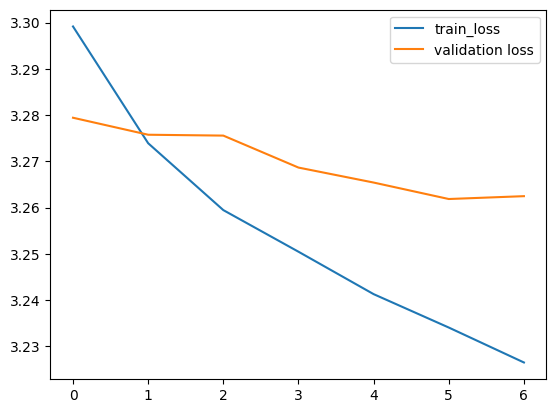

In [44]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [45]:
dummy_img = tf.zeros((1, 224, 224, 3)) 
dummy_txt = tf.zeros((1, 40))

_ = caption_model([dummy_img, dummy_txt])

caption_model.save_weights("my_caption_model.weights.h5")
print("Weights saved successfully!")

Weights saved successfully!


In [46]:
cnn_model = CNN_encoder()
encoder = TransformerEncoder(embed_dim, 1)
decoder = TransformerDecoder(
    num_layers=4,          
    embed_dim=256,
    units=512,
    num_heads=4,
    vocab_size=vocab_size,
    max_len=max_len
)

caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=None
)

dummy_img = tf.zeros((1, 224, 224, 3))
dummy_txt = tf.zeros((1, 40))

_ = caption_model([dummy_img, dummy_txt], training=False)

# 3. NOW load weights
caption_model.load_weights("my_caption_model.weights.h5")

print("Weights loaded successfully")

Weights loaded successfully


In [47]:
caption_model.summary()

Model: "image_captioning_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_2 (Functional)       │ (None, None, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ ?                      │       594,176 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_1           │ ?                      │     7,541,570 │
│ (TransformerDecoder)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,185,317 (46.48 MB)

 Trainable params: 8,135,746 (31.04 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [48]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(224, 224)(img)
    img = tf.cast(img, tf.float32)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

In [1]:
import pickle
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))

2026-01-07 03:44:07.642703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767757447.854487      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767757447.908146      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

I0000 00:00:1767757462.595806      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [2]:
import tensorflow as tf

In [3]:
vocab = tokenizer.get_vocabulary()
clean_vocab = [token for token in vocab if token not in ['', '[UNK]']]

word2idx = tf.keras.layers.StringLookup(
    vocabulary = clean_vocab,
    invert=False,
    mask_token = '',           
    oov_token = '[UNK]' 
)

idx2word = tf.keras.layers.StringLookup(
    vocabulary = clean_vocab,
    invert = True,
    mask_token = '',            
    oov_token = '[UNK]' 
)

In [6]:
%%time
start_id = int(tokenizer(["[start]"])[0,0].numpy())  
end_id   = int(tokenizer(["[end]"])[0,0].numpy())

CPU times: user 24.1 ms, sys: 162 µs, total: 24.2 ms
Wall time: 21.1 ms


In [49]:
def decode_ids_to_sentence(ids, idx2word):

    words = []
    for i in ids:
        if i == 0:              
            continue
        w = idx2word(tf.constant([i]))[0].numpy().decode("utf-8")
        if w in ("[start]", "[end]"):
            continue
        words.append(w)
    return " ".join(words)

In [50]:
def advanced_generate(img_path,
                      method="beam",     
                      beam_width=3,
                      top_k=40,
                      temperature=1.0,
                      repetition_penalty=1.2, # 1.1 - 1.5 is usually best
                      alpha=0.6,             # Length penalty weight
                      max_len=None):

    if max_len is None:
        max_len = MAX_LENGTH

    # --- Preprocessing & Encoding ---
    img = load_image_from_path(img_path)            
    img = tf.expand_dims(img, axis=0)                
    img_embed = caption_model.cnn_model(img)        
    encoder_output = caption_model.encoder(img_embed, training=False)

    start_id = int(tokenizer(["[start]"])[0,0].numpy())  
    end_id   = int(tokenizer(["[end]"])[0,0].numpy())
    unk_id   = 1 # As specified

    # ---------- HELPER: APPLY PENALTIES & MASK UNK ----------
    def process_logits(logits, current_seq):
        # 1. Mask UNK (Set to extremely low value)
        logits[unk_id] = -1e10
        
        # 2. Temperature scaling
        if temperature != 1.0:
            logits = logits / float(temperature)
            
        # 3. Repetition Penalty
        if repetition_penalty != 1.0:
            for tok in set(current_seq):
                # If logit is positive, decrease it; if negative, increase the magnitude
                if logits[tok] > 0:
                    logits[tok] /= repetition_penalty
                else:
                    logits[tok] *= repetition_penalty
        return logits

    # ---------- GREEDY ----------
    if method == "greedy":
        y = [start_id]
        for _ in range(max_len-1):
            inp = tf.constant([y], dtype=tf.int32)
            mask = tf.cast(inp != 0, tf.int32)
            preds = caption_model.decoder(inp, encoder_output, training=False, mask=mask)
            
            logits = np.log(np.clip(preds[0, -1, :].numpy(), 1e-9, 1.0))
            logits = process_logits(logits, y)
            
            next_id = int(np.argmax(logits))
            if next_id == end_id:
                break
            y.append(next_id)
        return decode_ids_to_sentence(y, idx2word)

    # ---------- BEAM SEARCH ----------
    if method == "beam":
        # (sequence, score)
        sequences = [([start_id], 0.0)]
        
        for _step in range(max_len-1):
            all_candidates = []
            for seq, score in sequences:
                if seq[-1] == end_id:
                    all_candidates.append((seq, score))
                    continue

                inp = tf.constant([seq], dtype=tf.int32)
                mask = tf.cast(inp != 0, tf.int32)
                preds = caption_model.decoder(inp, encoder_output, training=False, mask=mask)
                
                logits = np.log(np.clip(preds[0, -1, :].numpy(), 1e-9, 1.0))
                logits = process_logits(logits, seq)

                # Get top candidates
                top_ids = np.argsort(logits)[-beam_width:]
                for tok in top_ids:
                    candidate = seq + [int(tok)]
                    # Accumulate log-prob
                    new_score = score + float(logits[tok])
                    all_candidates.append((candidate, new_score))

            # Apply Length Penalty to scores before ranking
            # Formula: score / ((5 + L)^alpha / (5 + 1)^alpha)
            def get_lp_score(c_seq, c_score):
                lp = ((5 + len(c_seq))**alpha) / ((5 + 1)**alpha)
                return c_score / lp

            sequences = sorted(all_candidates, key=lambda x: get_lp_score(x[0], x[1]), reverse=True)[:beam_width]

            if all(seq[-1] == end_id for seq, sc in sequences):
                break

        return decode_ids_to_sentence(sequences[0][0], idx2word)

    # ---------- SAMPLING ----------
    if method == "sample":
        y = [start_id]
        for _ in range(max_len-1):
            inp = tf.constant([y], dtype=tf.int32)
            mask = tf.cast(inp != 0, tf.int32)
            preds = caption_model.decoder(inp, encoder_output, training=False, mask=mask)
            
            logits = np.log(np.clip(preds[0, -1, :].numpy(), 1e-9, 1.0))
            logits = process_logits(logits, y)

            # Top-K filtering
            topk_idx = np.argsort(logits)[-top_k:]
            topk_logits = logits[topk_idx]
            
            # Convert back to probabilities for random.choice
            exp_logits = np.exp(topk_logits - np.max(topk_logits))
            probs = exp_logits / np.sum(exp_logits)
            
            next_id = int(np.random.choice(topk_idx, p=probs))

            if next_id == end_id:
                break
            y.append(next_id)

        return decode_ids_to_sentence(y, idx2word)

    raise ValueError("Unknown method: choose 'greedy', 'beam', or 'sample'")

a large mirror with a toilet and other small window
a small bathroom with a toilet with a white dresser in it
a bathroom mirror with a toilet and an elegant bed
a picture of sink with tiled floor
a close up of a mirror that has a roll of tissue
CPU times: user 8.52 s, sys: 86.7 ms, total: 8.6 s
Wall time: 8.63 s


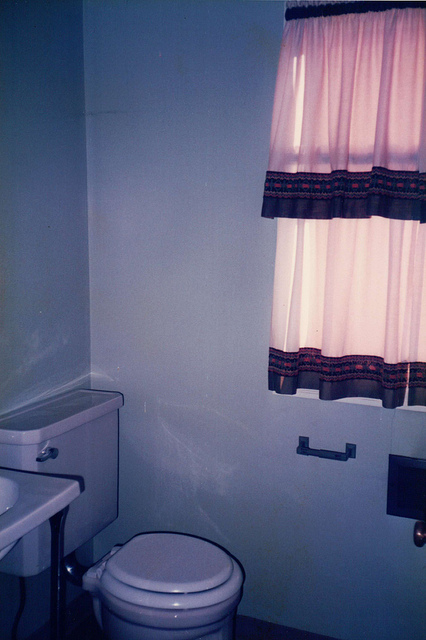

In [51]:
%%time
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image

for i in range(5):
    caption = advanced_generate(img_path, method="sample", temperature=1.2)
    print(caption)
    print('=========')

Image.open(img_path)

In [52]:
with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_PATH}/train2017/{x}'
)

In [53]:
captions = captions.groupby("image")['caption'].apply(list).reset_index()
captions["caption"] = captions["caption"].apply(lambda x: x[:5])
captions = captions[~captions['image'].isin(train_imgs)]
eval_df = captions.sample(n=300, random_state=42)

In [54]:
from tqdm import tqdm
import random

def generate_predictions(img_path):

    pred_caption = advanced_generate(
        img_path,
        method="beam",
        beam_width=3,
        temperature=1.0,
        repetition_penalty=1.2
    )

    return pred_caption

In [56]:
%%time
eval_df['predictions'] = eval_df['image'].apply(generate_predictions)

CPU times: user 19min 15s, sys: 8.28 s, total: 19min 24s
Wall time: 19min 22s


In [57]:
def tokenize(sent):
    return sent.lower().strip().split()

In [58]:
references = []
hypotheses = []

for _, row in eval_df.iterrows():
   
    hypotheses.append(tokenize(row.predictions))

    refs = [tokenize(c) for c in row.caption]
    references.append(refs)

In [136]:
from nltk.translate.bleu_score import corpus_bleu,SmoothingFunction
smooth = SmoothingFunction().method1

bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smooth)
bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

print("BLEU-1:", bleu1)
print("BLEU-2:", bleu2)
print("BLEU-3:", bleu3)
print("BLEU-4:", bleu4)

BLEU-1: 0.6453168906987369
BLEU-2: 0.47180776498786087
BLEU-3: 0.33646611333935905
BLEU-4: 0.2376430154122638


In [62]:
from nltk.translate.bleu_score import corpus_bleu,SmoothingFunction
smooth = SmoothingFunction().method1

bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smooth)
bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

print("BLEU-1:", bleu1)
print("BLEU-2:", bleu2)
print("BLEU-3:", bleu3)
print("BLEU-4:", bleu4)

BLEU-1: 0.6566188657583366
BLEU-2: 0.4779656692731381
BLEU-3: 0.3480447481107891
BLEU-4: 0.25169832099320977


In [64]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 18.1 MB/s eta 0:00:0000:0100:01


In [137]:
gts = {i: [" ".join(c) for c in references[i]] for i in range(300)}
res = {i: [" ".join(hypotheses[i])] for i in range(300)}

from pycocoevalcap.cider.cider import Cider

cider, _ = Cider().compute_score(gts, res)
print("CIDEr:", cider)

CIDEr: 0.7186078452222855


In [65]:
gts = {i: [" ".join(c) for c in references[i]] for i in range(300)}
res = {i: [" ".join(hypotheses[i])] for i in range(300)}

from pycocoevalcap.cider.cider import Cider

cider, _ = Cider().compute_score(gts, res)
print("CIDEr:", cider)

CIDEr: 0.7300209439600723
